imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import yfinance as yf
from sklearn.metrics import mean_squared_error, confusion_matrix, accuracy_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
#1.1 load data and correlation matrix
df_diabetes = pd.read_excel('Diabetes_Data.xlsx')
X_diab = df_diabetes.drop(columns=['Y'])
y_diab=df_diabetes['Y']

In [2]:
corr_matrix = df_diabetes.corr()

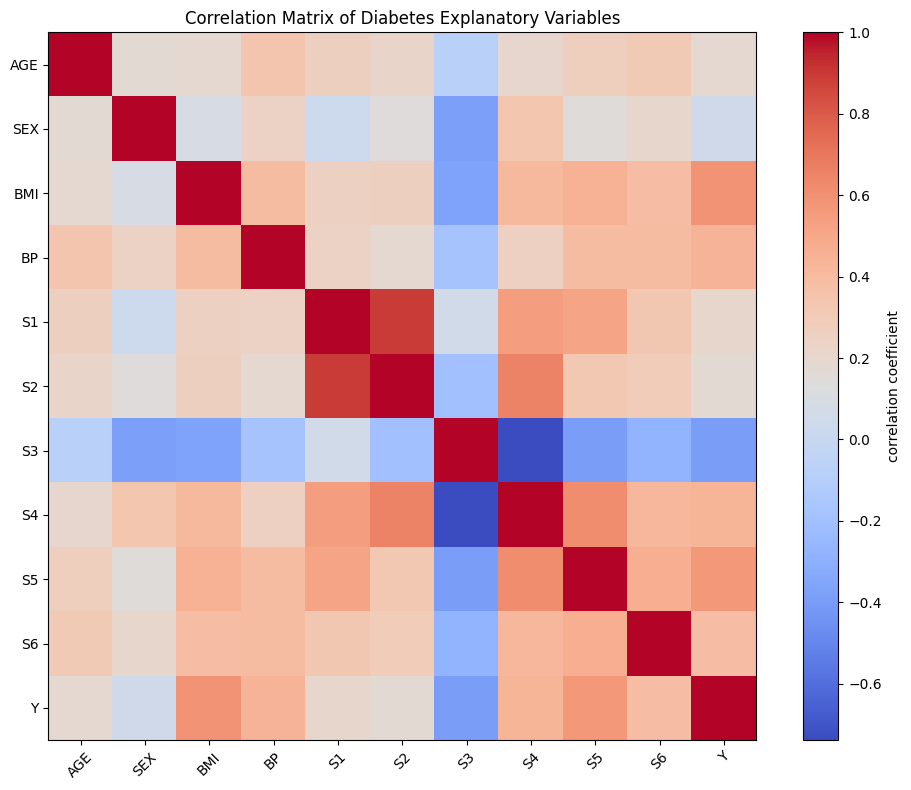

In [3]:
plt.figure(figsize=(10,8))
plt.imshow(corr_matrix, cmap='coolwarm',interpolation='nearest')
plt.colorbar(label='correlation coefficient')
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=45)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
plt.title("Correlation Matrix of Diabetes Explanatory Variables")
plt.tight_layout()
plt.show()

In [4]:
#1.3 multivariate linaer model
X_diab_const = sm.add_constant(X_diab)
model_diab = sm.OLS(y_diab, X_diab_const).fit()

In [5]:
#metrics
mse_diab = mean_squared_error(y_diab, model_diab.predict(X_diab_const))
adj_r2_diab = model_diab.rsquared_adj

In [6]:
print(f"MSE:{mse_diab:.4f}")
print(f"Adjusted R2:{adj_r2_diab:.4f}")
print(model_diab.summary())

MSE:2859.6963
Adjusted R2:0.5066
                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.518
Model:                            OLS   Adj. R-squared:                  0.507
Method:                 Least Squares   F-statistic:                     46.27
Date:                Sun, 11 Jan 2026   Prob (F-statistic):           3.83e-62
Time:                        07:29:08   Log-Likelihood:                -2386.0
No. Observations:                 442   AIC:                             4794.
Df Residuals:                     431   BIC:                             4839.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -334.56

In [7]:
#VIF for collinearity check
vif_data = pd.DataFrame()
vif_data["variable"] = X_diab.columns
vif_data["VIF"] = [variance_inflation_factor(X_diab.values, i)for i in range(len(X_diab.columns))]
print("\nVariance Inflation Factors:")
print(vif_data.sort_values(by="VIF", ascending = False))
#1.5 stepwise foward selection function
def forward_selection(data, target, significance_level=0.05):
  initial_features = data.columns.tolist()
  best_features= []
  while len(initial_features) >0:
       remaining_features = list(set(initial_features)-set(best_features))
       new_pval = pd.Series(index=remaining_features, dtype='float64')
       for new_column in remaining_features:
           model = sm.OLS(target, sm.add_constant(data[best_features +[new_column]])).fit()
           new_pval[new_column] = model.pvalues[new_column]
           min_p_value= new_pval.min()
       if min_p_value < significance_level:
          best_features.append(new_pval.idxmin())
       else:
          break
  return best_features


Variance Inflation Factors:
  variable         VIF
4       S1  576.886424
8       S5  277.183350
5       S2  244.913298
9       S6   93.976986
7       S4   81.350054
3       BP   69.404363
2      BMI   55.155355
6       S3   52.293365
0      AGE   17.876909
1      SEX   12.192347


In [8]:
selected_vars = forward_selection(X_diab, y_diab)
stepwise_model = sm.OLS(y_diab, sm.add_constant(X_diab[selected_vars])).fit()

In [9]:
print(f"selected variables:{selected_vars}")
print(f"stepwise MSE:{mean_squared_error(y_diab, stepwise_model.predict(sm.add_constant(X_diab[selected_vars]))):.4f}")
print(f"stepwise R2: {stepwise_model.rsquared:.4f}")
#2.2 load and probability
titanic = pd.read_csv('titanic3.csv')

selected variables:['BMI', 'S5', 'BP', 'S1', 'SEX', 'S2']
stepwise MSE:2876.6833
stepwise R2: 0.5149


In [10]:
survival_prob = titanic['survived'].mean()
print(f"Overall survival probability:{survival_prob:.4f}")
# Create age groups
bins = [0, 12, 18, 35, 60, 100]
labels = ["Child", "Teen", "Young Adult", "Adult", "Senior"]

Overall survival probability:0.3820


In [11]:
titanic["age_group"] = pd.cut(titanic["age"], bins=bins, labels=labels)

In [12]:
# Drop rows with missing values in key columns
titanic_clean = titanic.dropna(subset=["age_group", "sex", "pclass", "survived"])

In [13]:
# Calculate survival probabilities
survival_table = (
    titanic_clean
    .groupby(["pclass", "sex", "age_group"])["survived"]
    .mean()
    .reset_index()
)

C:\Users\USER\AppData\Local\Temp\ipykernel_13800\1260851269.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["pclass", "sex", "age_group"])["survived"]


In [14]:
survival_table.rename(columns={"survived": "Survival Probability"}, inplace=True)

In [15]:
#2.4 logistic regression
titanic_clean= titanic[['survived','pclass', 'sex', 'age']].dropna().copy()
titanic_clean['sex_binary'] = titanic_clean['sex'].map({'male':0,'female':1})
X_tit = sm.add_constant(titanic_clean[['pclass','sex_binary','age']])
y_tit = titanic_clean['survived']

In [16]:
logit_model = sm.Logit(y_tit, X_tit).fit()
print(logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.469897
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               survived   No. Observations:                 1046
Model:                          Logit   Df Residuals:                     1042
Method:                           MLE   Df Model:                            3
Date:                Sun, 11 Jan 2026   Pseudo R-squ.:                  0.3051
Time:                        07:29:09   Log-Likelihood:                -491.51
converged:                       True   LL-Null:                       -707.31
Covariance Type:            nonrobust   LLR p-value:                 3.167e-93
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.0919      0.371      5.633      0.000       1.364       2.820
pclass        -1.1332      0.

In [17]:
#2.5 perfomance
preds = (logit_model.predict(X_tit)>=0.5).astype(int)
accuracy = accuracy_score(y_tit,preds)
print(f"\nAccuracy:{accuracy:.5f}")
print("confusion_matrix:")
print(confusion_matrix(y_tit, preds))


Accuracy:0.78776
confusion_matrix:
[[523  96]
 [126 301]]


In [18]:
#3.3
tickers = ['UNH', 'GS', 'HD', 'AMGN', 'MCD', 'MSFT', 'CAT', 'HON', 'V', 'TRV', 'CVX', 'JNJ', 'BA', 'WMT', 'IBM', 'PG', 'AAPL', 'CRM', 'JPM', 'MMM', 'NKE', 'DIS', 'KO', 'DOW', 'CSCO', 'AMZN', 'VZ', 'INTC']
stock_data = yf.download(
    tickers,
      start='2020-01-01',
      end='2021-01-01'
      ).xs('Close', axis=1, level=0)
returns = stock_data.pct_change().dropna()
stock_corr = returns.corr()

[*********************100%***********************]  28 of 28 completed


In [19]:
#PCA implementation
scaler = StandardScaler()
scaled_returns = scaler.fit_transform(stock_corr)
pca = PCA()
pca.fit(scaled_returns)

PCA()

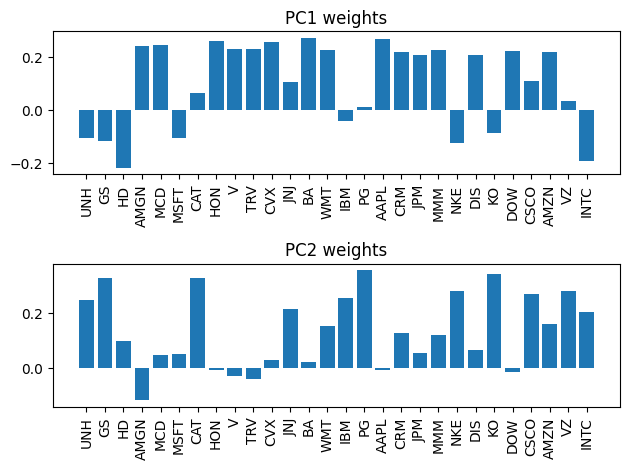

In [20]:
fig, (ax1, ax2)= plt.subplots(2, 1)
ax1.bar(tickers, pca.components_[0])
ax1.set_title('PC1 weights')
ax1.tick_params(axis='x', rotation=90)
ax2.bar(tickers, pca.components_[1])
ax2.set_title('PC2 weights')
ax2.tick_params(axis='x', rotation=90)
plt.tight_layout()
plt.show()
#3.4 scree plot

Number of components for 95% variance: 11


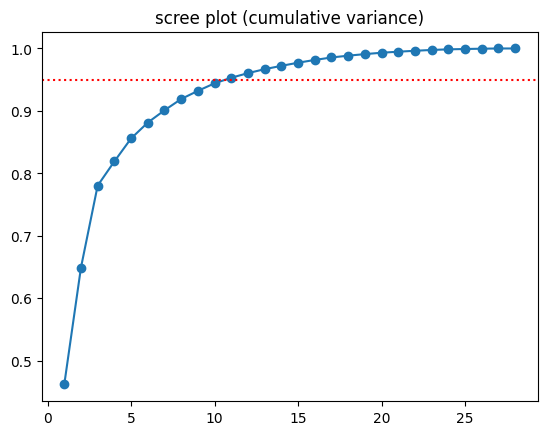

In [21]:
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
n_components_95 =  0
for i, var in enumerate(cumulative_variance):
    if var >= 0.95:
        n_components_95 = i + 1
        break
print(f"Number of components for 95% variance: {n_components_95}")
plt.figure()
plt.plot(range(1,len(cumulative_variance)+1),cumulative_variance, marker='o')
plt.axhline(y=0.95, color='r', linestyle=':' )
plt.title('scree plot (cumulative variance)')
plt.show()
#Euclidean distances
scores = pca.transform(scaled_returns)
mean_point = scores.mean(axis=0)

In [22]:
dist = np.linalg.norm(scores -mean_point, axis=1)
distance_df = pd.DataFrame({
    "Stock":tickers,
    "Distance":dist
 })

In [23]:
most_distant = (
   distance_df
   .sort_values("Distance", ascending=False)
   .head(3)["Stock"]
   .tolist() 
)
print(f"three most distant stocks: {most_distant}")

three most distant stocks: ['HD', 'INTC', 'MSFT']
